In [29]:
import os
import random
import re
from tqdm.notebook import tqdm
from collections import Counter

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

ROOT_DIR = "./data"
RANDOM_SEED = 110

np.random.seed(RANDOM_SEED)
%matplotlib inline

pd.options.display.max_columns = 200

In [56]:
# read csv
df_tr = pd.read_csv(os.path.join(ROOT_DIR, "train_v1.csv"))
df_te = pd.read_csv(os.path.join(ROOT_DIR, "test_v1.csv"))
df_list = [df_tr, df_te]

In [57]:
for df in df_list:
    df.drop(["Workorder"], axis=1, inplace=True)

### Scaling & Encoding

In [58]:
cat_features = ["Equipment_Dam",
                "Equipment_Fill1",
                "Equipment_Fill2",
                "Model.Suffix",
                # "Workorder",
                "Workorder Category",
                "Chamber Temp. Judge Value_AutoClave"]

# 여기서 Workorder 빼기로 함

bins_features = df_tr.columns[df_tr.columns.str.contains(r".*Bins.*")].tolist()
from_bins_features = [re.sub(r'\s*Bins\s*', '', f).strip() for f in bins_features]

cat_features.extend(bins_features)

In [59]:
for df in df_list:
    df[cat_features] = df[cat_features].astype("category")

In [60]:
num_features = df_tr.select_dtypes(exclude=["category"]).columns.to_list()
num_features.remove("target")

all_features = num_features + cat_features

In [61]:
# 우리가 파악해야하는 건 AbNormal이므로 1로 설정
df_tr["target"] = df_tr["target"].map({"Normal": 0, "AbNormal": 1})
# df_tr["target"] = df_tr["target"].map({0:"Normal", 1:"AbNormal"})

In [62]:
X_tr = df_tr.drop("target", axis=1)
y_tr = df_tr["target"]

X_te = df_te.drop("Set ID", axis=1)
set_id = df_te["Set ID"]

In [64]:
# ct = make_column_transformer(
#     (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_features),
#     (MinMaxScaler(), num_features),
#     remainder="passthrough",
# )

le = LabelEncoder()

for cat_feature in cat_features:
    X_tr[cat_feature] = le.fit_transform(X_tr[cat_feature])
    X_te[cat_feature] = le.transform(X_te[cat_feature])
   

mms = MinMaxScaler()

X_tr[num_features] = mms.fit_transform(X_tr[num_features])
X_te[num_features] = mms.transform(X_te[num_features])

In [66]:
X_tr.head()

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position X Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Re

### Resampling

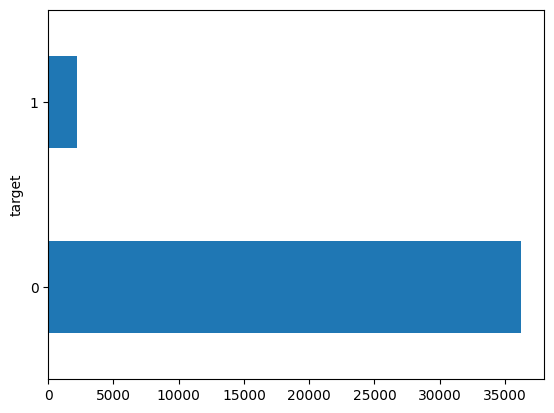

In [67]:
df_tr["target"].value_counts().plot(kind="barh");

In [68]:
def viz_pie(df):
    df["target"].value_counts().plot.pie(labels=["Normal", "AbNormal"], autopct=lambda x:f"{x:.2f}%");

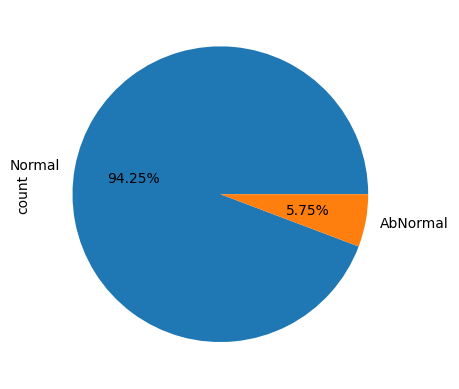

In [69]:
viz_pie(df_tr)

In [42]:
# ohe = ct.transformers_[0][1]
# ohe_cat_features = ohe.get_feature_names_out(cat_features)
# ohe_all_features = num_features + list(ohe_cat_features)

In [70]:
from sklearn.utils import resample
from imblearn.under_sampling import (NearMiss,
                                     ClusterCentroids,
                                     AllKNN,
                                     OneSidedSelection,
                                     TomekLinks)
from imblearn.over_sampling import (RandomOverSampler,
                                    SMOTE,
                                    ADASYN,
                                    SMOTENC,
                                    BorderlineSMOTE,
                                    KMeansSMOTE)

from imblearn.combine import SMOTEENN

def random_downsample(df, sample_ratio=1.0, random_seed=RANDOM_SEED):
    df_normal = df[df["target"] == 0] 
    df_abnormal = df[df["target"] == 1]
    
    downsampled = resample(
        df_normal,
        replace=False,
        n_samples=int(len(df_abnormal) * sample_ratio),
        random_state=random_seed
    )
    
    downsampled_df = pd.concat([df_abnormal, downsampled])
    
    return downsampled_df

def downsample(X, y, method, random_seed=RANDOM_SEED):
    # NearMiss
    if method == "nearmiss":
        # sampling_strategy="auto"
        nm = NearMiss(sampling_strategy=0.4)
        X_downsampled, y_downsampled = nm.fit_resample(X, y)
    # ClusterCentroids
    elif method == "cluster":
        cc = ClusterCentroids(random_state=random_seed)
        X_downsampled, y_downsampled = cc.fit_resample(X, y)
    # AllKNN
    elif method == "allknn":
        allknn = AllKNN()
        X_downsampled, y_downsampled = allknn.fit_resample(X, y)
    # OneSidedSelection
    elif method == "oneside":
        oss = OneSidedSelection(random_state=random_seed)
        X_downsampled, y_downsampled = oss.fit_resample(X, y)
    # Tomeklinks
    elif method == "tomek":
        tl = TomekLinks()
        X_downsampled, y_downsampled = tl.fit_resample(X, y)
    
    X_downsampled_df= pd.DataFrame(X_downsampled, columns=all_features)
    y_downsampled_df = pd.Series(y_downsampled, name="target") 
    downsampled_df = pd.concat([X_downsampled_df, y_downsampled_df], axis=1)
    
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_downsampled))
    
    return downsampled_df 

def upsample(X, y, cat_idx, method, random_seed=RANDOM_SEED):
    # X = df.drop("target", axis=1)
    # y = df["target"]
    
    if method == "random":
        ros = RandomOverSampler(random_state=random_seed)
        X_upsampled, y_upsampled = ros.fit_resample(X, y)
    # SMOTE
    if method == "smote":
        smote = SMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = smote.fit_resample(X, y)
    # ADASYN
    elif method == "adasyn":
        adasyn = ADASYN(random_state=random_seed)
        X_upsampled, y_upsampled = adasyn.fit_resample(X, y)
    # SMOTE-NC (both numerical & categorical features)
    elif method == "smotenc":
        smotenc = SMOTENC(random_state=random_seed, sampling_strategy="auto", categorical_features=cat_idx)
        X_upsampled, y_upsampled = smotenc.fit_resample(X, y)
    elif method == "borderline":
        borderline_smote = BorderlineSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = borderline_smote.fit_resample(X, y)
    elif method == "kmeans":
        kmeans_smote = KMeansSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = kmeans_smote.fit_resample(X, y)
        
    X_upsampled_df= pd.DataFrame(X_upsampled, columns=X_tr.columns)
    y_upsampled_df = pd.Series(y_upsampled, name="target") 
    upsampled_df = pd.concat([X_upsampled_df, y_upsampled_df], axis=1)
    
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_upsampled))
    
    return upsampled_df

In [71]:
# downsampled_df = random_downsample(df, sample_ratio=3.0)
downsample_options = {1:"nearmiss", 2:"cluster", 3:"allknn", 4:"oneside", 5:"tomek"}

downsampled_df_tr = downsample(X_tr, y_tr, method=downsample_options[5])

Original dataset shape Counter({0: 36197, 1: 2210})
Resampled dataset shape Counter({0: 35152, 1: 2210})


In [72]:
downsampled_df_tr.columns[downsampled_df_tr.isnull().any()]

Index([], dtype='object')

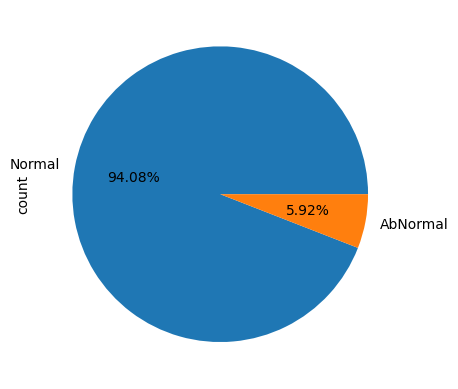

In [73]:
viz_pie(downsampled_df_tr)

In [74]:
upsample_options = {1: "random", 2:"smote", 3:"adasyn", 4:"smotenc", 5:"borderline", 6:"kmeans"}

cat_idx = [downsampled_df_tr.columns.get_loc(col) for col in cat_features]
X_tr = downsampled_df_tr.drop("target", axis=1)
y_tr = downsampled_df_tr["target"]

upsampled_df_tr = upsample(X_tr, y_tr, cat_idx, method=upsample_options[4])
# Counter(upsampled_df_tr['target'])

Original dataset shape Counter({0: 35152, 1: 2210})
Resampled dataset shape Counter({0: 35152, 1: 35152})


In [76]:
upsampled_df_tr.columns[downsampled_df_tr.isnull().any()]

Index([], dtype='object')

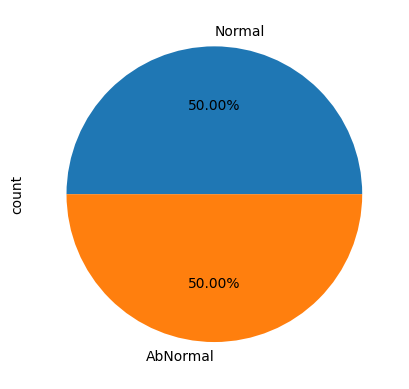

In [77]:
viz_pie(upsampled_df_tr)

In [78]:
X_tr = upsampled_df_tr.drop("target", axis=1)
y_tr = upsampled_df_tr["target"]

# X_tr = downsampled_df_tr.drop("target", axis=1)
# y_tr = downsampled_df_tr["target"]

### Feature Selection / Classification

In [79]:
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, precision_score, recall_score

import optuna
import warnings
warnings.filterwarnings('ignore')

In [80]:
classifiers = {
    "cat": CatBoostClassifier(random_state=RANDOM_SEED, auto_class_weights="Balanced"),
    "lgbm": LGBMClassifier(random_state=RANDOM_SEED,),
    "xgb": XGBClassifier(random_state=RANDOM_SEED, eval_metric='auc', objective="binary:logistic"),
    "ada": AdaBoostClassifier(random_state=RANDOM_SEED),
    "rfc": RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced'),
    "lr": LogisticRegression(random_state=RANDOM_SEED),
    "extra": ExtraTreesClassifier(random_state=RANDOM_SEED)
}

log_cols = ["model", "resample", "f1", "aucroc", "precision", "recall", "accuracy"]
log = pd.DataFrame(columns=log_cols)

DOWN = "AllKNN"
UP = "SMOTENC"
RESAMPLE = f"{DOWN}-{UP}"

def get_log(clf, X, y):
    y_prob = clf.predict_proba(X)
    y_pred = clf.predict(X)
    
    clf_name = clf.__class__.__name__
    f1 = f1_score(y,y_pred)
    aucroc = roc_auc_score(y, y_prob[:,1])
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    
    tmp_log = [clf_name, RESAMPLE, f1, aucroc, precision, recall, acc]
    # log = pd.concat([log, tmp_log], ignore_index=True)
    
    # print(classification_report(y, y_pred))
    
    return tmp_log

In [81]:
model = classifiers["extra"]
model.fit(X_tr, y_tr)

rfe = RFE(estimator=model, n_features_to_select=50)                                 
sfm = SelectFromModel(estimator=model, threshold="mean")
kbest = SelectKBest(score_func=f_classif,)

X_tr_selec = sfm.fit_transform(X_tr, y_tr)
X_te_selec = sfm.transform(X_te)

# # 수동
# selected_features = [feature for feature in all_features if feature not in from_bins_features] # 기존 열 대신 Bins 열 사용
# X_tr_selec = X_tr[selected_features]
# X_te_selec = X_te[selected_features]

print("Before ", X_tr.shape[1])
print("After ", X_tr_selec.shape[1])

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [82]:
print("Before ", X_tr.shape[1])
print("After ", X_tr_selec.shape[1])

Before  173
After  52


### Model Check

In [84]:
stk = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
rstk = RepeatedStratifiedKFold(n_splits=5, random_state=RANDOM_SEED)

# classifiers_lst = list(classifiers.values())

# # 기본 확인
# score_dic = {}
# for clf_name, clf in classifiers.items():
#     scores = cross_val_score(clf, X_tr_selec, y_tr, scoring="f1", cv=stk)
#     score_dic[clf_name] = scores.mean()

scores = cross_val_score(classifiers["cat"], X_tr_selec, y_tr, scoring="f1", cv=stk)

Learning rate set to 0.057572
0:	learn: 0.6361584	total: 5.55ms	remaining: 5.54s
1:	learn: 0.6114350	total: 11ms	remaining: 5.48s
2:	learn: 0.5729648	total: 16.4ms	remaining: 5.43s
3:	learn: 0.5584328	total: 22.3ms	remaining: 5.56s
4:	learn: 0.5418630	total: 27.3ms	remaining: 5.43s
5:	learn: 0.5335316	total: 32.5ms	remaining: 5.38s
6:	learn: 0.5212518	total: 38.3ms	remaining: 5.43s
7:	learn: 0.5107773	total: 43.7ms	remaining: 5.41s
8:	learn: 0.4943982	total: 48.4ms	remaining: 5.33s
9:	learn: 0.4764960	total: 53.1ms	remaining: 5.26s
10:	learn: 0.4687370	total: 58.4ms	remaining: 5.25s
11:	learn: 0.4625910	total: 63.4ms	remaining: 5.22s
12:	learn: 0.4571671	total: 69.2ms	remaining: 5.26s
13:	learn: 0.4460321	total: 74.3ms	remaining: 5.23s
14:	learn: 0.4372815	total: 78.8ms	remaining: 5.17s
15:	learn: 0.4316411	total: 84.1ms	remaining: 5.17s
16:	learn: 0.4247672	total: 90.1ms	remaining: 5.21s
17:	learn: 0.4103011	total: 95ms	remaining: 5.18s
18:	learn: 0.4059712	total: 99.8ms	remaining: 5.

In [85]:
scores.mean()

0.9687981798090188

In [87]:
# scores.mean()
score_dic

NameError: name 'score_dic' is not defined

### Tuning

In [88]:
def catboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
    }

    cat_clf = CatBoostClassifier(**params, random_state=RANDOM_SEED, auto_class_weights="Balanced",) # eval_metric="TotalF1"
    
    stk = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    f1_scores = np.empty(5)
    
    for idx, (tr_idx, val_idx) in enumerate(stk.split(X_tr_selec, y_tr)):
        X_tr_fold, X_val_fold = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
        y_tr_fold, y_val_fold = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]
        
        cat_clf.fit(X_tr_fold, y_tr_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=50, verbose=False)
        y_pred_fold = cat_clf.predict(X_val_fold)
        f1_scores[idx] = f1_score(y_val_fold, y_pred_fold)

    return np.mean(f1_scores)

cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(catboost_objective, n_trials=15)

cat_best_params = cat_study.best_params
cat_best_score = cat_study.best_value
print("CatBoost Best Hyperparams: ", cat_best_params)
print("CatBoost Best F1 Score: ", cat_best_score)

[I 2024-08-23 09:48:31,768] A new study created in memory with name: no-name-5bdb84d8-c42f-4be5-b79c-fe07e9296352
[I 2024-08-23 10:10:00,683] Trial 0 finished with value: 0.16048028847179666 and parameters: {'n_estimators': 778, 'learning_rate': 0.00039431087029899816, 'max_depth': 15, 'subsample': 0.7327089551885273, 'colsample_bylevel': 0.5946297136080188, 'od_type': 'IncToDec', 'od_wait': 24}. Best is trial 0 with value: 0.16048028847179666.
[I 2024-08-23 10:10:18,349] Trial 1 finished with value: 0.15433424610736954 and parameters: {'n_estimators': 705, 'learning_rate': 0.002851679326218497, 'max_depth': 6, 'subsample': 0.8378172117360276, 'colsample_bylevel': 0.5136930796946373, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 0 with value: 0.16048028847179666.
[I 2024-08-23 10:10:45,890] Trial 2 finished with value: 0.1601839467666007 and parameters: {'n_estimators': 285, 'learning_rate': 0.007174807636027618, 'max_depth': 10, 'subsample': 0.87261672072567, 'colsample_bylevel

CatBoost Best Hyperparams:  {'n_estimators': 830, 'learning_rate': 0.0014280646210236597, 'max_depth': 15, 'subsample': 0.585499340271016, 'colsample_bylevel': 0.920959485443428, 'od_type': 'Iter', 'od_wait': 31}
CatBoost Best F1 Score:  0.16751550033413198


In [ ]:
tmp = {'n_estimators': 111, 'learning_rate': 0.126311103030899, 'max_depth': 10, 'subsample': 0.7975270504932956, 'colsample_bylevel': 0.5141440123828669}

In [ ]:
CatBoost Best Hyperparams:  {'n_estimators': 830, 'learning_rate': 0.0014280646210236597, 'max_depth': 15, 'subsample': 0.585499340271016, 'colsample_bylevel': 0.920959485443428, 'od_type': 'Iter', 'od_wait': 31}
CatBoost Best F1 Score:  0.16751550033413198

In [96]:
def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    
    lgbm_clf = LGBMClassifier(**params, random_state=RANDOM_SEED)
    
    stk = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    f1_scores = np.empty(5)
    
    for idx, (tr_idx, val_idx) in enumerate(stk.split(X_tr_selec, y_tr)):
        X_tr_fold, X_val_fold = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
        y_tr_fold, y_val_fold = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]
        
        lgbm_clf.fit(X_tr_fold,
                      y_tr_fold, 
                      eval_set = [(X_val_fold, y_val_fold)],
                      eval_metric = 'f1',
                      )
        
        y_pred_fold = lgbm_clf.predict(X_val_fold)
        f1_scores[idx] = f1_score(y_val_fold, y_pred_fold)

    return np.mean(f1_scores)
    
study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective, n_trials=15)

lgbm_best_params = study.best_params
lgbm_best_score= study.best_value
print("LGBM Best Hyperparams: ",lgbm_best_params)
print("LGBM Best F1 Score: ", lgbm_best_score)

[I 2024-08-23 21:36:33,317] A new study created in memory with name: no-name-3a074f67-dc2d-4898-b627-dfd60735f3e9


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:37:48,975] Trial 0 finished with value: 0.9699931545102419 and parameters: {'n_estimators': 822, 'learning_rate': 0.04648943430946607, 'max_depth': 20, 'num_leaves': 259, 'subsample': 0.5616207637667308, 'colsample_bytree': 0.731836385318132}. Best is trial 0 with value: 0.9699931545102419.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:38:15,928] Trial 1 finished with value: 0.9265772360038248 and parameters: {'n_estimators': 145, 'learning_rate': 0.0035953794553535727, 'max_depth': 12, 'num_leaves': 727, 'subsample': 0.6198923511240945, 'colsample_bytree': 0.7922808467971727}. Best is trial 0 with value: 0.9699931545102419.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:38:39,859] Trial 2 finished with value: 0.935416159679769 and parameters: {'n_estimators': 291, 'learning_rate': 0.004151474651706996, 'max_depth': 9, 'num_leaves': 904, 'subsample': 0.7821470301930467, 'colsample_bytree': 0.5338527140549976}. Best is trial 0 with value: 0.9699931545102419.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:39:56,084] Trial 3 finished with value: 0.9708282562778662 and parameters: {'n_estimators': 483, 'learning_rate': 0.015618420534872182, 'max_depth': 19, 'num_leaves': 460, 'subsample': 0.6506730726692983, 'colsample_bytree': 0.593543117650918}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:40:39,434] Trial 4 finished with value: 0.9701816816600779 and parameters: {'n_estimators': 378, 'learning_rate': 0.020772232495606734, 'max_depth': 16, 'num_leaves': 326, 'subsample': 0.8778201101221605, 'colsample_bytree': 0.8121578002601431}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:41:22,498] Trial 5 finished with value: 0.9698688013631378 and parameters: {'n_estimators': 879, 'learning_rate': 0.04007950050973799, 'max_depth': 9, 'num_leaves': 243, 'subsample': 0.8030979384104943, 'colsample_bytree': 0.6952649055676055}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-08-23 21:42:05,241] Trial 6 finished with value: 0.9326725144097834 and parameters: {'n_estimators': 159, 'learning_rate': 0.0018787218267675193, 'max_depth': 15, 'num_leaves': 824, 'subsample': 0.8236912031931811, 'colsample_bytree': 0.8436862063641708}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:44:52,720] Trial 7 finished with value: 0.9700360928819454 and parameters: {'n_estimators': 964, 'learning_rate': 0.041244468229164236, 'max_depth': 20, 'num_leaves': 930, 'subsample': 0.815181099095204, 'colsample_bytree': 0.7786657291936194}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:45:13,640] Trial 8 finished with value: 0.9628690243363878 and parameters: {'n_estimators': 173, 'learning_rate': 0.027779290780557388, 'max_depth': 11, 'num_leaves': 601, 'subsample': 0.5491532476034708, 'colsample_bytree': 0.8208015958030512}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-08-23 21:48:12,025] Trial 9 finished with value: 0.9653380946788042 and parameters: {'n_estimators': 823, 'learning_rate': 0.004114089322246225, 'max_depth': 14, 'num_leaves': 747, 'subsample': 0.6440857329281275, 'colsample_bytree': 0.8418862594957701}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:48:26,850] Trial 10 finished with value: 0.9372215617725714 and parameters: {'n_estimators': 614, 'learning_rate': 0.012615249182943829, 'max_depth': 5, 'num_leaves': 55, 'subsample': 0.9904528596257001, 'colsample_bytree': 0.9973463204639123}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-23 21:49:16,634] Trial 11 finished with value: 0.9698689231719809 and parameters: {'n_estimators': 485, 'learning_rate': 0.09933377955832916, 'max_depth': 17, 'num_leaves': 380, 'subsample': 0.9346054649679562, 'colsample_bytree': 0.587327580895377}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:50:23,358] Trial 12 finished with value: 0.9705702496970858 and parameters: {'n_estimators': 465, 'learning_rate': 0.013885578459392747, 'max_depth': 17, 'num_leaves': 505, 'subsample': 0.7093383929615682, 'colsample_bytree': 0.6481997171220719}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:51:54,309] Trial 13 finished with value: 0.9704550825151251 and parameters: {'n_estimators': 594, 'learning_rate': 0.008689206240237245, 'max_depth': 18, 'num_leaves': 515, 'subsample': 0.6999809614043409, 'colsample_bytree': 0.6343759098986507}. Best is trial 3 with value: 0.9708282562778662.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28122, number of negative: 28121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21698
[LightGBM] [Info] Number of data points in the train set: 56243, number of used features: 173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000036
[LightGBM] [Info] Start training from score 0.000036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-23 21:53:09,204] Trial 14 finished with value: 0.9706149783661168 and parameters: {'n_estimators': 467, 'learning_rate': 0.009794691809236856, 'max_depth': 18, 'num_leaves': 579, 'subsample': 0.7054585044638961, 'colsample_bytree': 0.5094430075247659}. Best is trial 3 with value: 0.9708282562778662.


LGBM Best Hyperparams:  {'n_estimators': 483, 'learning_rate': 0.015618420534872182, 'max_depth': 19, 'num_leaves': 460, 'subsample': 0.6506730726692983, 'colsample_bytree': 0.593543117650918}
LGBM Best F1 Score:  0.9708282562778662


LGBM Best Hyperparams:  {'n_estimators': 483, 'learning_rate': 0.015618420534872182, 'max_depth': 19, 'num_leaves': 460, 'subsample': 0.6506730726692983, 'colsample_bytree': 0.593543117650918}
LGBM Best F1 Score:  0.9708282562778662

In [98]:
def xgboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # colsample_bylevel -> colsample_bytree
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # XGBoost의 중요한 파라미터 중 하나
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),  # 트리의 분할을 조정하는 파라미터
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),  # L1 정규화 항
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),  # L2 정규화 항
    }

    xgb_clf = XGBClassifier(**params, random_state=RANDOM_SEED, use_label_encoder=False, early_stopping_rounds=50, eval_metric='logloss')
    
    stk = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    f1_scores = np.empty(5)
    
    for idx, (tr_idx, val_idx) in enumerate(stk.split(X_tr_selec, y_tr)):
        X_tr_fold, X_val_fold = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
        y_tr_fold, y_val_fold = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]
        
        xgb_clf.fit(X_tr_fold, y_tr_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
        y_pred_fold = xgb_clf.predict(X_val_fold)
        f1_scores[idx] = f1_score(y_val_fold, y_pred_fold)

    return np.mean(f1_scores)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgboost_objective, n_trials=15)

xgb_best_params = xgb_study.best_params
xgb_best_score = xgb_study.best_value
print("XGBoost Best Hyperparams: ", xgb_best_params)
print("XGBoost Best F1 Score: ", xgb_best_score)


[I 2024-08-23 21:58:30,115] A new study created in memory with name: no-name-37d3fcc8-74e0-444d-9088-09d07c7fc98e
[I 2024-08-23 21:58:42,291] Trial 0 finished with value: 0.9041634045381441 and parameters: {'n_estimators': 254, 'learning_rate': 0.00017636713497169466, 'max_depth': 9, 'subsample': 0.6118773417564034, 'colsample_bytree': 0.5242274677053846, 'min_child_weight': 6, 'gamma': 0.02350903779674661, 'reg_alpha': 8.483917069712579e-08, 'reg_lambda': 0.2236610093568261}. Best is trial 0 with value: 0.9041634045381441.
[I 2024-08-23 21:59:05,515] Trial 1 finished with value: 0.9585099861569111 and parameters: {'n_estimators': 621, 'learning_rate': 0.018803952777929935, 'max_depth': 7, 'subsample': 0.9352151655340075, 'colsample_bytree': 0.5413133960002618, 'min_child_weight': 2, 'gamma': 0.0006425364033202869, 'reg_alpha': 1.9477151109046983e-07, 'reg_lambda': 1.5724327180367265e-07}. Best is trial 1 with value: 0.9585099861569111.
[I 2024-08-23 21:59:36,607] Trial 2 finished with

XGBoost Best Hyperparams:  {'n_estimators': 824, 'learning_rate': 0.03547634614711746, 'max_depth': 12, 'subsample': 0.5234544553569108, 'colsample_bytree': 0.6460877569056785, 'min_child_weight': 1, 'gamma': 3.124133166446926e-06, 'reg_alpha': 0.002450809453263128, 'reg_lambda': 0.9024969978496601}
XGBoost Best F1 Score:  0.9702372340371556


### Submission

In [ ]:
final_clf = CatBoostClassifier(**tmp, random_state=RANDOM_SEED, auto_class_weights="Balanced",)
# final_clf = LGBMClassifier(**lgbm_best_params, random_state=RANDOM_SEED)

final_clf.fit(X_tr_selec, y_tr, use_best_model=True)
final_preds = final_clf.predict(X_te_selec)

In [ ]:
df_sub = pd.read_csv(os.path.join(ROOT_DIR, "submission.csv"))
df_sub["target"] = final_preds
df_sub["target"] = df_sub["target"].map({0:"Normal", 1:"AbNormal"})
df_sub["target"].value_counts()

In [ ]:
from datetime import datetime

curr_date = datetime.now().strftime("%m-%d_%H-%M-%S")
df_sub.to_csv(os.path.join(ROOT_DIR, f"submission_{curr_date}.csv"))